Génération de données pour 15 patients avec maximum 2 opérations par patient

=== DONNÉES GÉNÉRÉES ALÉATOIREMENT ===
Patient 1: 2 opérations
  Opération 1: [(3, 1), (2, 1), (5, 1)]
  Opération 2: [(4, 1), (1, 1), (5, 1)]
Patient 2: 2 opérations
  Opération 1: [(2, 1), (5, 2), (4, 2)]
  Opération 2: [(2, 2)]
Patient 3: 2 opérations
  Opération 1: [(2, 2), (6, 1)]
  Opération 2: [(4, 1)]
Patient 4: 2 opérations
  Opération 1: [(5, 1), (3, 2)]
  Opération 2: [(1, 2), (4, 2), (6, 1)]
Patient 5: 2 opérations
  Opération 1: [(6, 1)]
  Opération 2: [(1, 1), (2, 2)]
Patient 6: 2 opérations
  Opération 1: [(6, 1), (3, 2)]
  Opération 2: [(2, 1), (3, 1)]
Patient 7: 2 opérations
  Opération 1: [(4, 2)]
  Opération 2: [(6, 1), (5, 2)]
Patient 8: 2 opérations
  Opération 1: [(1, 2)]
  Opération 2: [(3, 1), (1, 2)]
Patient 9: 2 opérations
  Opération 1: [(4, 1), (6, 2), (5, 1)]
  Opération 2: [(6, 2)]
Patient 10: 2 opérations
  Opération 1: [(4, 1), (3, 2), (2, 1)]
  Opération 2: [(1, 1)]
Patient 11

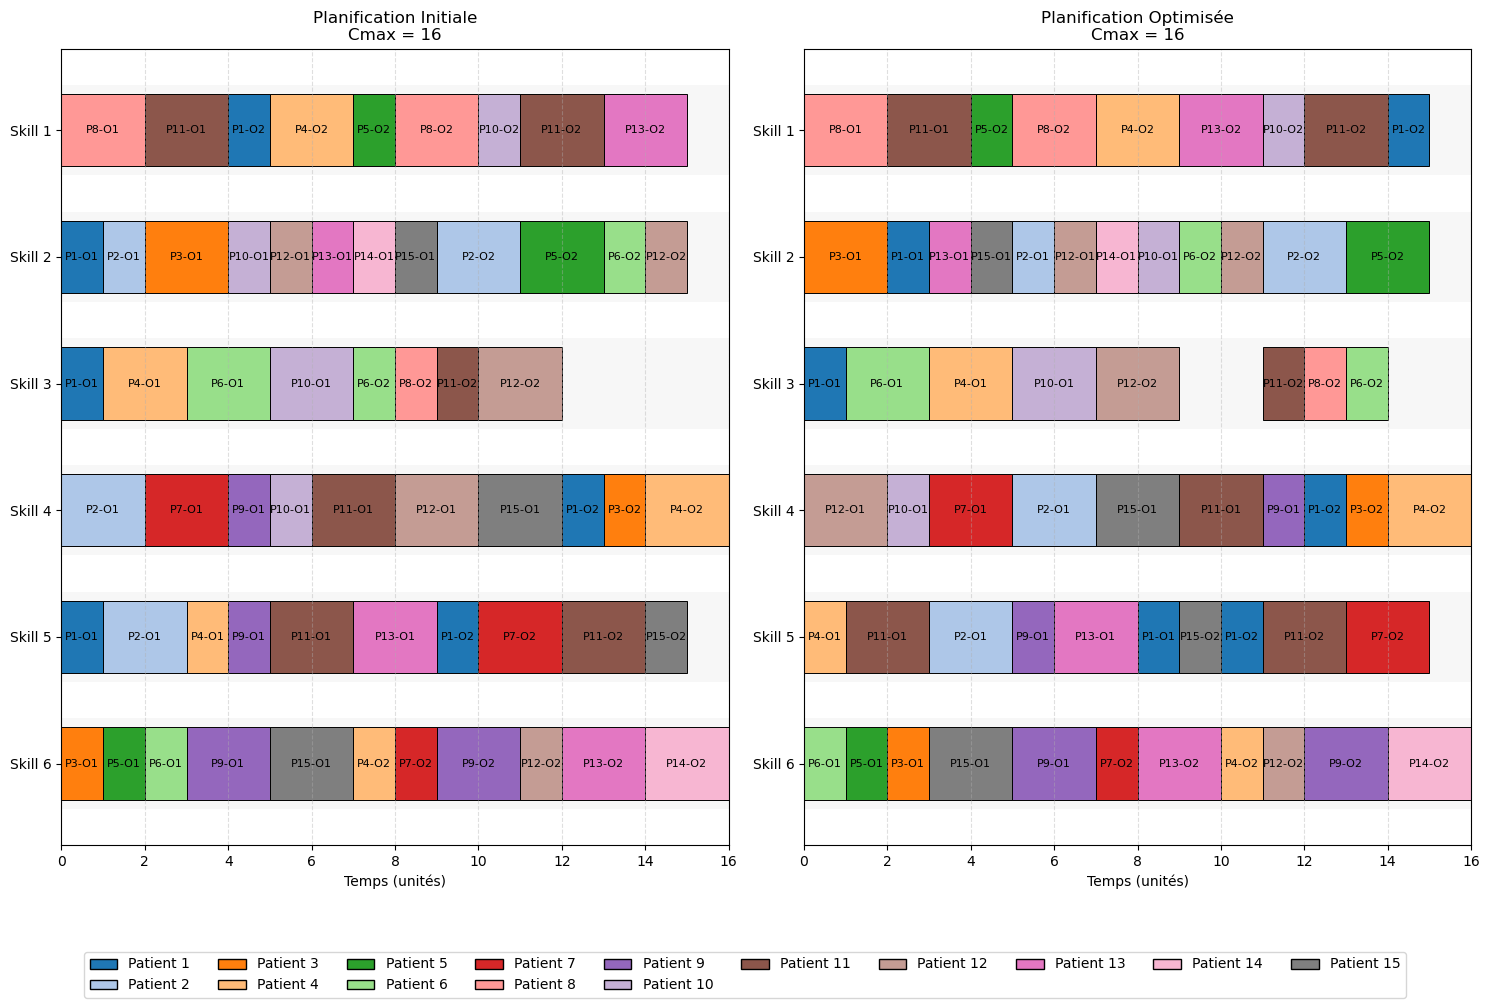

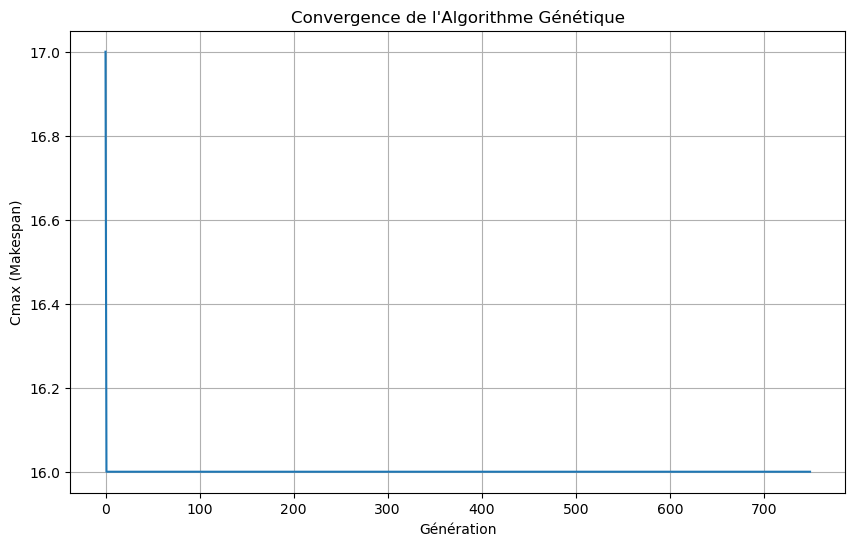


=== STATISTIQUES DÉTAILLÉES ===
Nombre total de tâches planifiées: 60

Efficacité initiale: 92.7%
Efficacité optimisée: 92.7%
Amélioration d'efficacité: 0.0%
Minimum théorique: 14.8


In [1]:
from copy import deepcopy
import random
from collections import defaultdict, namedtuple
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import math
import numpy as np

# --- Global Constants avec génération aléatoire ---
random.seed(42)

# Paramètres aléatoires pour la génération des données
NUM_PATIENTS = random.randint(5, 15)  # Entre 5 et 15 patients
MAX_OPS = random.randint(2, 6)        # Entre 2 et 6 opérations max par patient
SKILLS = [1, 2, 3, 4, 5, 6]

print(f"Génération de données pour {NUM_PATIENTS} patients avec maximum {MAX_OPS} opérations par patient")

# ---------------------------
# Random Data Generation
# ---------------------------
def generate_random_data(num_patients, max_ops, skills):
    """Génère des données aléatoires pour les patients et leurs opérations."""
    data = {}
    
    for patient_id in range(1, num_patients + 1):
        patient_ops = {}
        num_operations = random.randint(2, max_ops)  # Nombre d'opérations pour ce patient
        
        for op_id in range(1, num_operations + 1):
            # Nombre aléatoire de compétences requises (1-3)
            num_required_skills = random.randint(1, min(3, len(skills)))
            required_skills = random.sample(skills, num_required_skills)
            
            # Durée aléatoire pour chaque compétence (1-2 unités)
            operations = []
            for skill in required_skills:
                duration = random.randint(1, 2)
                operations.append((skill, duration))
            
            patient_ops[op_id] = operations
        
        # Pour les opérations non utilisées, liste vide
        for op_id in range(num_operations + 1, max_ops + 1):
            patient_ops[op_id] = []
            
        data[patient_id] = patient_ops
    
    return data

# Génération des données aléatoires
DATA = generate_random_data(NUM_PATIENTS, MAX_OPS, SKILLS)

# Affichage des données générées
print("\n=== DONNÉES GÉNÉRÉES ALÉATOIREMENT ===")
for patient_id, operations in DATA.items():
    num_ops = sum(1 for ops in operations.values() if ops)
    print(f"Patient {patient_id}: {num_ops} opérations")
    for op_id, skills in operations.items():
        if skills:
            print(f"  Opération {op_id}: {skills}")

# ---------------------------
# Data Structure and Task Creation
# ---------------------------
def create_task(num_patients, data, max_ops):
    """Crée toutes les tâches et les structures d'indexation."""
    Task = namedtuple("Task", ["i", "j", "s", "p"])
    ALL_TASKS = []
    TASKS_BY_SKILL_STAGE = defaultdict(list)
    PATIENT_LAST_STAGE = {i: 0 for i in range(1, num_patients + 1)}

    for i in range(1, num_patients + 1):
        if i in data:
            for j in range(1, max_ops + 1):
                ops = data[i].get(j, [])
                if ops:
                    PATIENT_LAST_STAGE[i] = j
                for (s, p) in ops:
                    t = Task(i=i, j=j, s=s, p=p)
                    ALL_TASKS.append(t)
                    TASKS_BY_SKILL_STAGE[(s, j)].append(t)

    return ALL_TASKS, TASKS_BY_SKILL_STAGE, PATIENT_LAST_STAGE

# Execute task creation
ALL_TASKS, TASKS_BY_SKILL_STAGE, PATIENT_LAST_STAGE = create_task(NUM_PATIENTS, DATA, MAX_OPS)

# Statistiques des tâches générées
total_tasks = len(ALL_TASKS)
print(f"\n=== STATISTIQUES DES TÂCHES ===")
print(f"Nombre total de tâches: {total_tasks}")
print(f"Nombre de patients: {NUM_PATIENTS}")
print(f"Opérations maximum par patient: {MAX_OPS}")

# Répartition par compétence
skill_distribution = defaultdict(int)
for task in ALL_TASKS:
    skill_distribution[task.s] += 1

print("Répartition par compétence:")
for skill in SKILLS:
    print(f"  Compétence {skill}: {skill_distribution[skill]} tâches")

# ---------------------------
# Initial Sequence Building (pour le Gantt de départ)
# ---------------------------
def build_initial_sequences(skills, max_ops, tasks_by_skill_stage):
    """
    Construit une séquence initiale de tâches (ordre naïf : patients croissants).
    """
    seq = {}
    for s in skills:
        for j in range(1, max_ops + 1):
            tasks = tasks_by_skill_stage.get((s, j), [])
            if tasks:
                # Ordre naïf = patients croissants
                ordered_tasks = sorted(tasks, key=lambda t: (t.i))
                seq[(s, j)] = ordered_tasks
    return seq

# Construction de la séquence initiale
initial_sequences = build_initial_sequences(SKILLS, MAX_OPS, TASKS_BY_SKILL_STAGE)

# ---------------------------
# Evaluation Function
# ---------------------------
def evaluate_schedule(sequences, skills, num_patients, data, patient_last_stage, max_ops, return_schedule=False):
    """
    Évalue une solution et retourne le makespan.
    """
    # disponibilité des ressources
    res_free = {s: 0 for s in skills}
    # fin de l'étape j pour chaque patient
    op_completion = { (i, 0): 0 for i in range(1, num_patients + 1) }
    task_times = {}

    for j in range(1, max_ops + 1):
        stage_finish = defaultdict(int)
        
        for s in skills:
            tasks = sequences.get((s, j), [])
            for t in tasks:
                ready = op_completion[(t.i, j - 1)]
                start = max(res_free[s], ready)
                finish = start + t.p
                res_free[s] = finish
                stage_finish[t.i] = max(stage_finish[t.i], finish)
                task_times[(t.i, j, s)] = (start, finish, t.p)
                
        for i in range(1, num_patients + 1):
            if data[i].get(j, []):
                op_completion[(i, j)] = stage_finish[i]
            else:
                op_completion[(i, j)] = op_completion[(i, j - 1)]

    makespan = 0
    for i in range(1, num_patients + 1):
        last_j = patient_last_stage[i]
        makespan = max(makespan, op_completion[(i, last_j)])

    if return_schedule:
        return makespan, task_times, op_completion
    
    return makespan

# ---------------------------
# Genetic Algorithm Implementation
# ---------------------------
class GeneticAlgorithm:
    def __init__(self, skills, num_patients, data, patient_last_stage, max_ops, 
                 population_size=20, crossover_rate=0.75, mutation_rate=0.025, generations=2000):
        self.skills = skills
        self.num_patients = num_patients
        self.data = data
        self.patient_last_stage = patient_last_stage
        self.max_ops = max_ops
        self.population_size = population_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.generations = generations
        
        # Structures de données des tâches
        self.ALL_TASKS, self.TASKS_BY_SKILL_STAGE, _ = create_task(num_patients, data, max_ops)
    
    def generate_individual(self):
        """Génère un individu (séquence) aléatoire."""
        individual = {}
        for s in self.skills:
            for j in range(1, self.max_ops + 1):
                tasks = self.TASKS_BY_SKILL_STAGE.get((s, j), [])
                if tasks:
                    # Créer une permutation aléatoire des tâches
                    shuffled_tasks = tasks.copy()
                    random.shuffle(shuffled_tasks)
                    individual[(s, j)] = shuffled_tasks
        return individual
    
    def generate_initial_population(self):
        """Génère la population initiale."""
        return [self.generate_individual() for _ in range(self.population_size)]
    
    def evaluate_individual(self, individual):
        """Évalue un individu (plus le makespan est petit, meilleur est l'individu)."""
        return evaluate_schedule(
            sequences=individual,
            skills=self.skills,
            num_patients=self.num_patients,
            data=self.data,
            patient_last_stage=self.patient_last_stage,
            max_ops=self.max_ops
        )
    
    def tournament_selection(self, population, fitness_scores, tournament_size=3):
        """Sélection par tournoi."""
        selected = []
        for _ in range(len(population)):
            # Choisir k individus au hasard
            indices = random.sample(range(len(population)), tournament_size)
            # Sélectionner le meilleur (makespan le plus petit)
            best_idx = min(indices, key=lambda idx: fitness_scores[idx])
            selected.append(deepcopy(population[best_idx]))
        return selected
    
    def ordered_crossover(self, parent1, parent2):
        """Croisement ordonné pour les séquences."""
        child = {}
        
        for key in set(parent1.keys()) | set(parent2.keys()):
            seq1 = parent1.get(key, [])
            seq2 = parent2.get(key, [])
            
            if not seq1 or not seq2 or random.random() > self.crossover_rate:
                # Prendre le parent1 par défaut
                child[key] = deepcopy(seq1)
                continue
            
            # Points de croisement
            if len(seq1) > 1:
                point1 = random.randint(0, len(seq1) - 2)
                point2 = random.randint(point1 + 1, len(seq1) - 1)
                
                # Segment du parent1
                segment = seq1[point1:point2]
                
                # Remplir avec les éléments du parent2 dans l'ordre
                remaining = [task for task in seq2 if task not in segment]
                child_seq = remaining[:point1] + segment + remaining[point1:]
                child[key] = child_seq
            else:
                child[key] = deepcopy(seq1)
                
        return child
    
    def swap_mutation(self, individual):
        """Mutation par échange de deux tâches dans une séquence."""
        mutated = deepcopy(individual)
        
        for key in mutated:
            if mutated[key] and random.random() < self.mutation_rate:
                seq = mutated[key]
                if len(seq) > 1:
                    i, j = random.sample(range(len(seq)), 2)
                    seq[i], seq[j] = seq[j], seq[i]
        
        return mutated
    
    def run(self):
        """Exécute l'algorithme génétique."""
        # Population initiale
        population = self.generate_initial_population()
        best_individual = None
        best_fitness = float('inf')
        fitness_history = []
        
        print(f"\nDémarrage de l'algorithme génétique pour {self.num_patients} patients...")
        
        for generation in range(self.generations):
            # Évaluation
            fitness_scores = []
            for individual in population:
                fitness = self.evaluate_individual(individual)
                fitness_scores.append(fitness)
                
                if fitness < best_fitness:
                    best_fitness = fitness
                    best_individual = deepcopy(individual)
            
            fitness_history.append(best_fitness)
            
            # Sélection
            selected = self.tournament_selection(population, fitness_scores)
            
            # Croisement et mutation
            new_population = []
            for i in range(0, len(selected), 2):
                if i + 1 < len(selected):
                    parent1, parent2 = selected[i], selected[i + 1]
                    child1 = self.ordered_crossover(parent1, parent2)
                    child2 = self.ordered_crossover(parent2, parent1)
                    
                    child1 = self.swap_mutation(child1)
                    child2 = self.swap_mutation(child2)
                    
                    new_population.extend([child1, child2])
                else:
                    new_population.append(self.swap_mutation(selected[i]))
            
            # Élitisme
            if best_individual:
                # Remplacer le pire individu par le meilleur
                worst_idx = max(range(len(new_population)), 
                              key=lambda i: self.evaluate_individual(new_population[i]))
                new_population[worst_idx] = deepcopy(best_individual)
            
            population = new_population
            
            if generation % 100 == 0:
                print(f"Génération {generation}: Best Cmax = {best_fitness}")
        
        return best_individual, best_fitness, fitness_history

# ---------------------------
# Visualization Functions
# ---------------------------
def _patient_colors(num_patients):
    """Palette stable pour n patients."""
    cmap = plt.colormaps.get_cmap("tab20")
    n = min(20, num_patients)
    return {i+1: cmap(i / 19) for i in range(num_patients)}

def build_gantt_data(task_times, skills):
    """Re-formate task_times -> dict skill -> liste d'items triés"""
    by_skill = {s: [] for s in skills}
    horizon = 0
    for (i, j, s), (start, finish, p) in task_times.items():
        by_skill[s].append({
            "start": start, "end": finish, "dur": p,
            "patient": i, "op": j
        })
        horizon = max(horizon, finish)
        
    for s in skills:
        by_skill[s].sort(key=lambda x: (x["start"], x["patient"], x["op"]))
        
    return by_skill, horizon

def plot_gantt_comparison(initial_times, optimized_times, skills, num_patients, 
                         initial_cmax, optimized_cmax, figsize=(15, 10)):
    """Affiche les diagrammes de Gantt avant et après côte à côte."""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    colors = _patient_colors(num_patients)
    
    # Fonction pour tracer un Gantt sur un axe donné
    def plot_single_gantt(ax, task_times, title, makespan):
        by_skill, horizon = build_gantt_data(task_times, skills)
        
        lane_height = 0.8
        y_gap = 0.6
        y_positions = {s: (len(skills)-idx-1)*(lane_height + y_gap) for idx, s in enumerate(skills)}
        ymin = -0.5
        ymax = max(y_positions.values()) + lane_height + 0.5

        # Dessin des rectangles
        for s in skills:
            y = y_positions[s]
            ax.add_patch(Rectangle((0, y - 0.1), horizon, lane_height + 0.2,
                                   facecolor=(0,0,0,0.03), edgecolor="none"))
            for it in by_skill[s]:
                start = it["start"]
                dur   = it["dur"]
                i     = it["patient"]
                j     = it["op"]
                rect = Rectangle((start, y), dur, lane_height,
                                 facecolor=colors[i], edgecolor="black", linewidth=0.7)
                ax.add_patch(rect)
                label = f"P{i}-O{j}"
                ax.text(start + dur/2, y + lane_height/2, label,
                        ha="center", va="center", fontsize=8)

        # Configuration des axes
        ax.set_xlim(0, math.ceil(horizon) if horizon > 0 else 1)
        ax.set_ylim(ymin, ymax)
        ax.set_xlabel("Temps (unités)")
        ax.set_yticks([y_positions[s] + lane_height/2 for s in skills])
        ax.set_yticklabels([f"Skill {s}" for s in skills])
        ax.set_title(f"{title}\nCmax = {makespan}")
        ax.grid(axis="x", linestyle="--", alpha=0.4)
    
    # Tracer le Gantt initial
    plot_single_gantt(ax1, initial_times, "Planification Initiale", initial_cmax)
    
    # Tracer le Gantt optimisé
    plot_single_gantt(ax2, optimized_times, "Planification Optimisée", optimized_cmax)
    
    # Légende commune
    legend_handles = [Patch(facecolor=colors[i], edgecolor="black", label=f"Patient {i}") 
                     for i in range(1, num_patients + 1)]
    fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.05), 
               ncol=min(10, num_patients), frameon=True)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Ajuster pour la légende
    plt.show()

def plot_convergence(fitness_history, title="Convergence de l'Algorithme Génétique"):
    """Affiche la courbe de convergence."""
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_history)
    plt.title(title)
    plt.xlabel("Génération")
    plt.ylabel("Cmax (Makespan)")
    plt.grid(True)
    plt.show()

# ---------------------------
# Main Execution
# ---------------------------
if __name__ == "__main__":
    # Ajustement dynamique des paramètres basé sur la taille du problème
    population_size = max(20, NUM_PATIENTS * 2)
    generations = max(500, NUM_PATIENTS * 50)
    
    print(f"\n=== CONFIGURATION DE L'ALGORITHME ===")
    print(f"Taille de la population: {population_size}")
    print(f"Nombre de générations: {generations}")
    
    # Évaluation de la solution initiale
    print("\n=== ÉVALUATION DE LA SOLUTION INITIALE ===")
    initial_cmax, initial_times, _ = evaluate_schedule(
        sequences=initial_sequences,
        skills=SKILLS,
        num_patients=NUM_PATIENTS,
        data=DATA,
        patient_last_stage=PATIENT_LAST_STAGE,
        max_ops=MAX_OPS,
        return_schedule=True
    )
    print(f"Cmax initial: {initial_cmax}")
    
    # Configuration de l'algorithme génétique
    ga = GeneticAlgorithm(
        skills=SKILLS,
        num_patients=NUM_PATIENTS,
        data=DATA,
        patient_last_stage=PATIENT_LAST_STAGE,
        max_ops=MAX_OPS,
        population_size=population_size,
        crossover_rate=0.75,
        mutation_rate=0.025,
        generations=generations
    )
    
    # Exécution de l'algorithme
    best_solution, best_cmax, history = ga.run()
    
    print(f"\n=== RÉSULTATS FINAUX ===")
    print(f"Cmax initial: {initial_cmax}")
    print(f"Meilleur Cmax trouvé: {best_cmax}")
    improvement = ((initial_cmax - best_cmax) / initial_cmax) * 100
    print(f"Amélioration: {improvement:.2f}%")
    
    # Évaluation détaillée de la meilleure solution
    optimized_cmax, optimized_times, op_completion = evaluate_schedule(
        sequences=best_solution,
        skills=SKILLS,
        num_patients=NUM_PATIENTS,
        data=DATA,
        patient_last_stage=PATIENT_LAST_STAGE,
        max_ops=MAX_OPS,
        return_schedule=True
    )
    
    print(f"Cmax vérifié: {optimized_cmax}")
    
    # Affichage des diagrammes de Gantt comparatifs
    print("\n=== COMPARAISON VISUELLE ===")
    plot_gantt_comparison(
        initial_times=initial_times,
        optimized_times=optimized_times,
        skills=SKILLS,
        num_patients=NUM_PATIENTS,
        initial_cmax=initial_cmax,
        optimized_cmax=optimized_cmax
    )
    
    # Courbe de convergence
    plot_convergence(history)
    
    # Statistiques détaillées
    print(f"\n=== STATISTIQUES DÉTAILLÉES ===")
    total_tasks = sum(len(tasks) for tasks in best_solution.values())
    print(f"Nombre total de tâches planifiées: {total_tasks}")
    
    # Performance relative
    theoretical_min = max(
        max(sum(task.p for task in ga.ALL_TASKS if task.i == i) for i in range(1, NUM_PATIENTS + 1)),
        sum(task.p for task in ga.ALL_TASKS) / len(SKILLS)
    )
    initial_efficiency = (theoretical_min / initial_cmax) * 100 if initial_cmax > 0 else 0
    optimized_efficiency = (theoretical_min / optimized_cmax) * 100 if optimized_cmax > 0 else 0
    
    print(f"\nEfficacité initiale: {initial_efficiency:.1f}%")
    print(f"Efficacité optimisée: {optimized_efficiency:.1f}%")
    print(f"Amélioration d'efficacité: {optimized_efficiency - initial_efficiency:.1f}%")
    print(f"Minimum théorique: {theoretical_min:.1f}")